In [0]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque
#import pybullet_envs
!pip install box2d-py
!pip install gym[Box_2D]

In [0]:
from multiprocessing import Process, Pipe
import numpy as np

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)
        

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

In [235]:
env_name = "MountainCarContinuous-v0" #"MountainCarContinuous-v0"  #Pendulum-v0 LunarLanderContinuous-v2
env = gym.make(env_name)
def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk
env_nums = 12
envs = [make_env() for i in range(env_nums)]
envs = SubprocVecEnv(envs)

print("action space: ", env.action_space.shape[0])
print("observation space ", env.env.observation_space.shape[0])
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device)

GAMMA = 0.9
ENTROPY_BETA = 0.001  
CLIP_GRAD = .1
LR = 2e-3
HIDDEN_SIZE = 256

action space:  1
observation space  2
Using:  cpu


In [0]:
class A2C_Conti(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(A2C_Conti, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
#                                  nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
#                                  nn.ReLU()
                                 )
        self.critic = nn.Sequential(nn.Linear(HIDDEN_SIZE, 1))          # estimated Value of the state
        self.mean = nn.Sequential(nn.Linear(HIDDEN_SIZE, output_shape),
                                  nn.Tanh())                    # tanh squashed output to the range of -1..1
        self.variance =nn.Sequential(nn.Linear(HIDDEN_SIZE, output_shape),
                                     nn.Softplus())             # log(1 + e^x) has the shape of a smoothed ReLU
    
    def forward(self,x):
        x = self.net(x)
        return self.mean(x), self.variance(x), self.critic(x)
      

def test_net(net, env, count = 10):
    rewards = 0.0
    steps = 0
    entropys = 0.0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = torch.from_numpy(obs).unsqueeze(0).float()
            mean_v, var_v, v_ = net(obs_v.to(device))
            action, _, entropy = sample(mean_v[0].cpu(), var_v[0].cpu())
            obs, reward, done, info = env.step(action.numpy())
            
            rewards += reward
            entropys += np.mean(entropy.detach().numpy())
            steps += 1
            if done:
                break

    return rewards/count, entropys/count, steps/count
  

  
def compute_returns(reward_history, mask_history, gamma=GAMMA):
    env_rewards = list(zip(*reward_history))
    env_masks = list(zip(*mask_history))
    dicounted_reward_tensor = []
    for idx, rewards in enumerate(env_rewards):
      R = 0 
      returns = []
      for step in reversed(range(len(rewards))):
          R = rewards[step] + gamma * R * env_masks[idx][step]
          returns.insert(0, R)
      dicounted_reward_tensor.append(returns)
    #print(dicounted_reward_tensor)
    return torch.FloatTensor(dicounted_reward_tensor)#.reshape(-1).unsqueeze(1)

def sample(mean, variance):
  """
  Calculates the actions, log probs and entropy based on a normal distribution by a given mean and variance.
  
  ====================================================
  
  calculate log prob:
  log_prob = -((action - mean) ** 2) / (2 * var) - log(sigma) - log(sqrt(2 *pi))
  
  calculate entropy:
  entropy =  0.5 + 0.5 * log(2 *pi * sigma) 
  entropy here relates directly to the unpredictability of the actions which an agent takes in a given policy.
  The greater the entropy, the more random the actions an agent takes.
  
  """
  sigma = torch.sqrt(variance)
  m = Normal(mean, sigma)
  actions = m.sample()
  actions = torch.clamp(actions, -1, 1) # usually clipping between -1,1 but pendulum env has action range of -2,2
  logprobs = m.log_prob(actions)
  entropy = m.entropy()  # Equation: 0.5 + 0.5 * log(2 *pi * sigma)
    
  return actions, logprobs, entropy


def run_optimization(logprob_batch, entropy_batch, values_batch, rewards_batch, masks):
    """
    Calculates the actor loss and the critic loss and backpropagates it through the Network
    
    ============================================
    Critic loss:
    c_loss = MSE(Value, discounted reward)
    
    a_loss = -logprob * advantage
    
    """
    
    log_prob_v = torch.cat(logprob_batch, dim = -2).to(device)
    entropy_v = torch.cat(entropy_batch, dim = 1).to(device)
    value_v = torch.cat(values_batch, dim = 1).to(device)
    
    
    optimizer.zero_grad()
    discounted_rewards = compute_returns(rewards_batch, masks).to(device)
    
    # critic_loss 
    critic_loss = F.mse_loss(value_v, discounted_rewards)

    # A(s,a) = Q(s,a) - V(s)
    advantage = discounted_rewards - value_v.detach() 

    #actor_loss
    actor_loss = (-log_prob_v * advantage.transpose(dim0 = 1, dim1 = 0).reshape(-1).unsqueeze(1)).mean()
      
    loss =  actor_loss + 0.5 * critic_loss + ENTROPY_BETA * entropy.detach().mean()

    loss.backward()
    clip_grad_norm_(model.parameters(),CLIP_GRAD)
    optimizer.step()
    return actor_loss, critic_loss

Episode: 490 | Ep_Reward: -0.15 | Average_100: -1.64

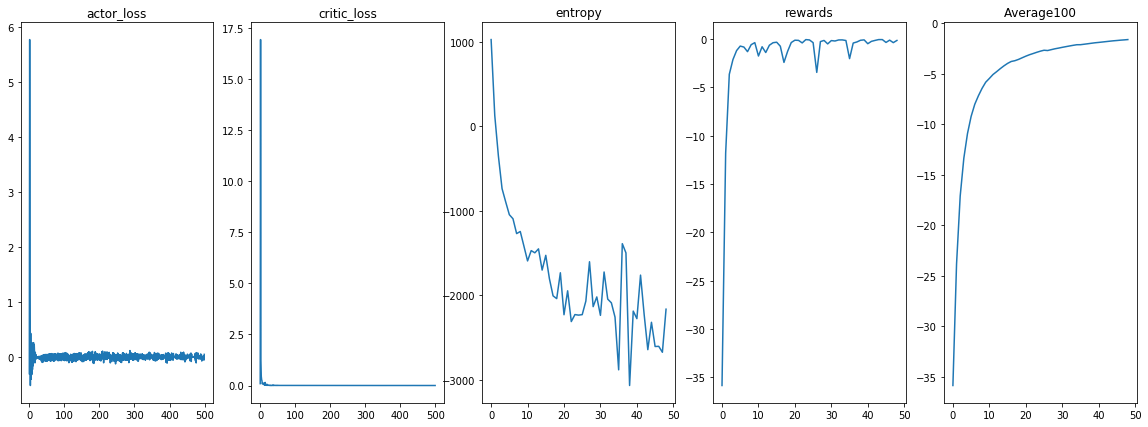

In [237]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

input_shape  = env.observation_space.shape[0]
output_shape = env.action_space.shape[0]

model = A2C_Conti(input_shape, output_shape).to(device)
optimizer = optim.RMSprop(params = model.parameters(),lr = LR)

max_episodes = 500

actor_loss_list = []
critic_loss_list = []
entropy_list = []


average_100 = []
plot_rewards = []
steps = 0
max_steps = 200

for ep in range(max_episodes):
    states = envs.reset()
    done = False

    logprob_batch = []
    entropy_batch = []
    values_batch = []
    rewards_batch = []
    masks = []
    for step in range(max_steps):
        states = torch.from_numpy(states).float()
        mean, variance, value = model(states.to(device))   
        action, logprob, entropy = sample(mean.cpu(), variance.cpu())
        next_states, reward, done, _ = envs.step(action.numpy())

        logprob_batch.append(logprob)
        entropy_batch.append(entropy)
        values_batch.append(value)
        rewards_batch.append(reward)  
        masks.append(1 - done)

        states = next_states

        if np.any(done):
          break

    actor_loss, critic_loss = run_optimization(logprob_batch, entropy_batch, values_batch, \
                                                rewards_batch, masks)
    
    actor_loss_list.append(actor_loss)
    critic_loss_list.append(critic_loss)
    
    if ep != 0 and ep % 10 == 0:
      test_rewards, test_entropy, test_steps = test_net(model, env)
      entropy_list.append(test_entropy)
      plot_rewards.append(test_rewards)

      average_100.append(np.mean(plot_rewards[-100:]))
      print("\rEpisode: {} | Ep_Reward: {:.2f} | Average_100: {:.2f}".format(ep, test_rewards, np.mean(plot_rewards[-100:])), end = "", flush = True)
        
        

    

# PLOTTING RESULTS

plt.figure(figsize = (20,7))
plt.subplot(1,5,1)
plt.title("actor_loss")
plt.plot(actor_loss_list)
plt.subplot(1,5,2)
plt.title("critic_loss")
plt.plot(critic_loss_list)
plt.subplot(1,5,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,5,4)
plt.title("rewards")
plt.plot(plot_rewards)
plt.subplot(1,5,5)
plt.title("Average100")
plt.plot(average_100)
plt.show()